<a href="https://colab.research.google.com/github/amr552/Deep-Learning/blob/NLP/compars%C4%B1on%20pre_trained_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Epoch 1/50
83/83 [==============================] - 198s 2s/step - loss: 0.8912 - accuracy: 0.7171 - val_loss: 0.1893 - val_accuracy: 0.9333
Epoch 2/50
83/83 [==============================] - 159s 2s/step - loss: 0.3703 - accuracy: 0.8540 - val_loss: 0.1364 - val_accuracy: 0.9667
Epoch 3/50
83/83 [==============================] - 158s 2s/step - loss: 0.3089 - accuracy: 0.8820 - val_loss: 0.0914 - val_accuracy: 0.9833
Epoch 4/50
83/83 [==============================] - 151s 2s/step - loss: 0.2293 - accuracy: 0.9145 - val_loss: 0.0899 - val_accuracy: 0.9667
Epoch 5/50
83/83 [==============================] - 153s 2s/step - loss: 0.2126 - accuracy: 0.9206 - val_loss: 0.1075 - val_accuracy: 0.9667
Epoch 6/50
83/83 [=========================

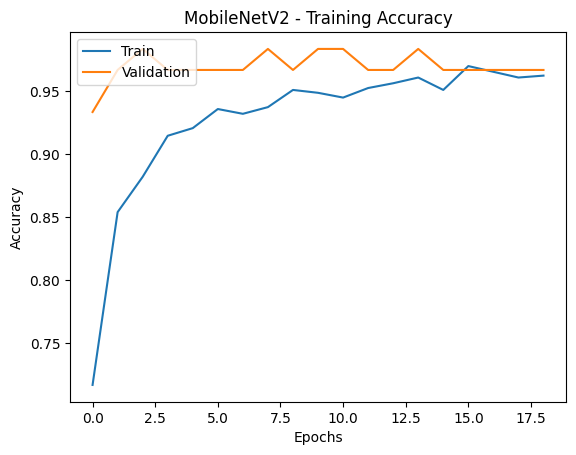

10/10 [==============================] - 14s 1s/step - loss: 0.1413 - accuracy: 0.9733
Test Accuracy: 0.9733
10/10 [==============================] - 14s 1s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.21      0.22      0.21        50
     Powdery       0.22      0.20      0.21        50
        Rust       0.31      0.32      0.32        50

    accuracy                           0.25       150
   macro avg       0.25      0.25      0.25       150
weighted avg       0.25      0.25      0.25       150

Confusion Matrix:
[[11 24 15]
 [20 10 20]
 [22 12 16]]


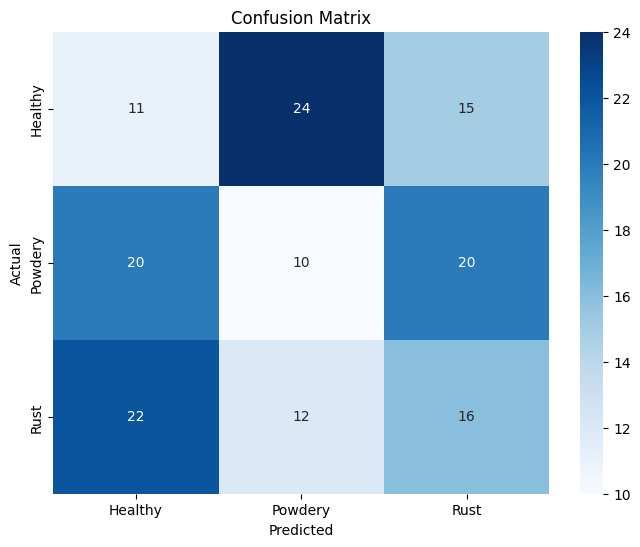

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/datasets/plant disease/savedmodels/MobileNetV2.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Dropout,AveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to your training and test datasets

train_dir = "/content/drive/MyDrive/datasets/plant disease/Train/Train"
test_dir = "/content/drive/MyDrive/datasets/plant disease/Test/Test"
val_dir = "/content/drive/MyDrive/datasets/plant disease/Validation/Validation"
# Set the image dimensions and batch size
img_width, img_height = 224,224
batch_size = 16

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model
base_model.trainable = False

# Add new layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjust the output layer for 3 classes
])

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

# Generate training accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("MobileNetV2 - Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate classification report and confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()




model_save_path = "/content/drive/MyDrive/datasets/plant disease/savedmodels/MobileNetV2.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/25
83/83 [==============================] - 161s 2s/step - loss: 1.0171 - accuracy: 0.7307 - val_loss: 0.1129 - val_accuracy: 0.9500
Epoch 2/25
83/83 [==============================] - 148s 2s/step - loss: 0.3852 - accuracy: 0.8623 - val_loss: 0.0504 - val_accuracy: 1.0000
Epoch 3/25
83/83 [==============================] - 152s 2s/step - loss: 0.2670 - accuracy: 0.9047 - val_loss: 0.0460 - val_accuracy: 0.9833
Epoch 4/25
83/83 [==============================] - 144s 2s/step - loss: 0.2241 - accuracy: 0.9191 - val_loss: 0.0306 - val_accuracy: 1.0000
Epoch 5/25
83/83 [==============================] - 146s 2s/step - loss: 0.1986 - accuracy: 0.9297 - val_loss: 0.0317 -

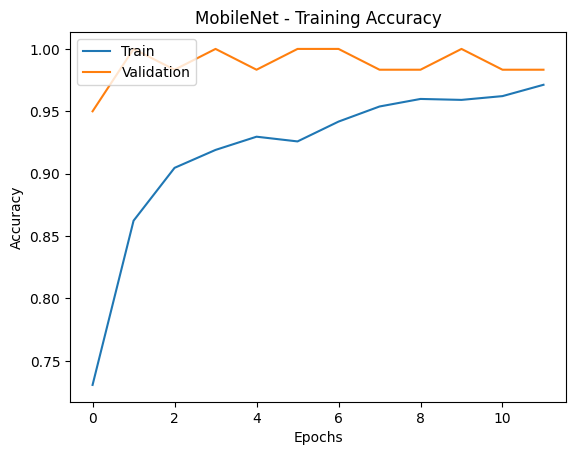

10/10 [==============================] - 14s 1s/step - loss: 0.1929 - accuracy: 0.9400
Test Accuracy: 0.9400
10/10 [==============================] - 14s 1s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.26      0.28      0.27        50
     Powdery       0.39      0.36      0.37        50
        Rust       0.36      0.36      0.36        50

    accuracy                           0.33       150
   macro avg       0.34      0.33      0.33       150
weighted avg       0.34      0.33      0.33       150

Confusion Matrix:
[[14 16 20]
 [20 18 12]
 [20 12 18]]


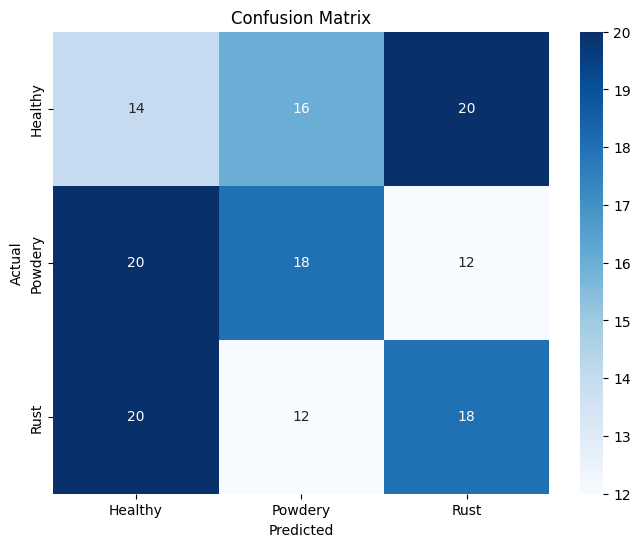

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/datasets/plant disease/savedmodels/MobileNet.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Dropout,AveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to your training and test datasets

train_dir = "/content/drive/MyDrive/datasets/plant disease/Train/Train"
test_dir = "/content/drive/MyDrive/datasets/plant disease/Test/Test"
val_dir = "/content/drive/MyDrive/datasets/plant disease/Validation/Validation"
# Set the image dimensions and batch size
img_width, img_height = 224,224
batch_size = 16

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model
base_model.trainable = False

# Add new layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjust the output layer for 3 classes
])

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

# Generate training accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("MobileNet - Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate classification report and confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


model_save_path = "/content/drive/MyDrive/datasets/plant disease/savedmodels/MobileNet.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/25
41/41 [==============================] - 879s 20s/step - loss: 1.2034 - accuracy: 0.7550 - val_loss: 0.6839 - val_accuracy: 0.9688
Epoch 2/25
41/41 [==============================] - 777s 19s/step - loss: 0.6309 - accuracy: 0.9628 - val_loss: 0.6136 - val_accuracy: 0.9688
Epoch 3/25
41/41 [==============================] - 772s 19s/step - loss: 0.5672 - accuracy: 0.9713 - val_loss: 0.4752 - val_accuracy: 1.0000
Epoch 4/25
41/41 [==============================] - 770s 19s/step - loss: 0.5184 - accuracy: 0.9853 - val_loss: 0.4668 - val_accuracy: 1.0000
Epoch 5/25
41/41 [==============================] - 788s 19s/step - loss: 0.4875 - accuracy: 0.9915 - val_loss: 0.6

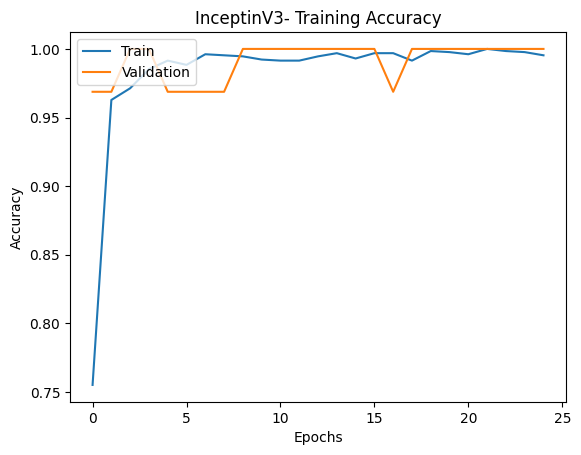

5/5 [==============================] - 59s 13s/step - loss: 0.4700 - accuracy: 0.9667
Test Accuracy: 0.9667
5/5 [==============================] - 30s 5s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.34      0.36      0.35        50
     Powdery       0.23      0.22      0.23        50
        Rust       0.20      0.20      0.20        50

    accuracy                           0.26       150
   macro avg       0.26      0.26      0.26       150
weighted avg       0.26      0.26      0.26       150

Confusion Matrix:
[[18 15 17]
 [16 11 23]
 [19 21 10]]


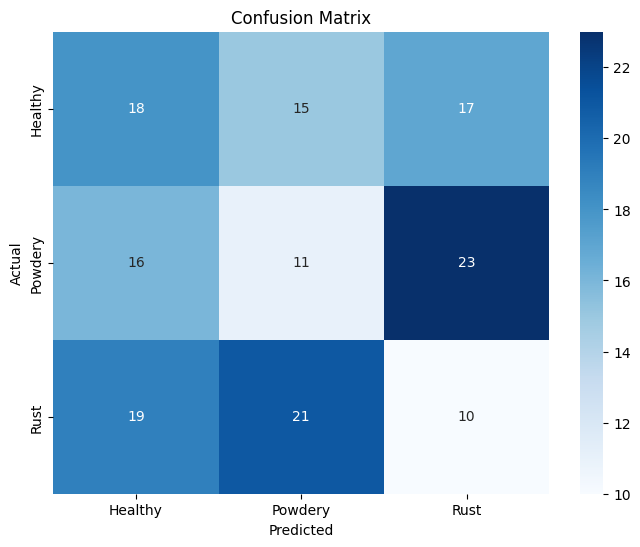

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/datasets/plant_disease/savedmodels/inceptionV3_1.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import save_model
import seaborn as sns


# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to your training and test datasets
# Set the paths to your training and test datasets
train_dir = "/content/drive/MyDrive/datasets/plant disease/Train/Train"
test_dir = "/content/drive/MyDrive/datasets/plant disease/Test/Test"
val_dir = "/content/drive/MyDrive/datasets/plant disease/Validation/Validation"
# Set the image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,  # Reduce shearing intensity
    zoom_range=0.1,  # Reduce zooming intensity
    rotation_range=10,
    #shear_range=0.2,
    #zoom_range=0.2,
    #rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training and test sets with data augmentation

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
)

model =InceptionV3(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))


base_model = model
model_name = base_model.__class__.__name__

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
# Add Dropout layer with 20% dropout rate
model.add(Dropout(0.2))  # Experiment with different dropout rates

# Dense layer with L2 regularization (weight decay)
model.add(Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Adjust weight decay as needed
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation="softmax"))

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"],

)

# Train the model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=25,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[early_stopping]
)

# Generate training accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("InceptinV3- Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate classification report and confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

model_save_path = "/content/drive/MyDrive/datasets/plant_disease/savedmodels/inceptionV3_1.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9202 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 1381s 33s/step - loss: 0.2231 - accuracy: 0.9202 - val_loss: 5.7741e-07 - val_accuracy: 1.0000
Epoch 2/10
41/41 [==============================] - 1381s 34s/step - loss: 0.0523 - accuracy: 0.9853 - val_loss: 0.3512 - val_accuracy: 0.8438
Epoch 3/10
41/41 [==============================] - 1367s 33s/step - loss: 0.1070 - accuracy: 0.9643 - val_loss: 1.5818 - val_accuracy: 0.9688
Epoch 4/10
41/41 [==============================] - 1373s 33s/step - loss: 0.0577 - accuracy: 0.9860 - val_loss: 7.1823e-05 - val_accuracy: 1.0000


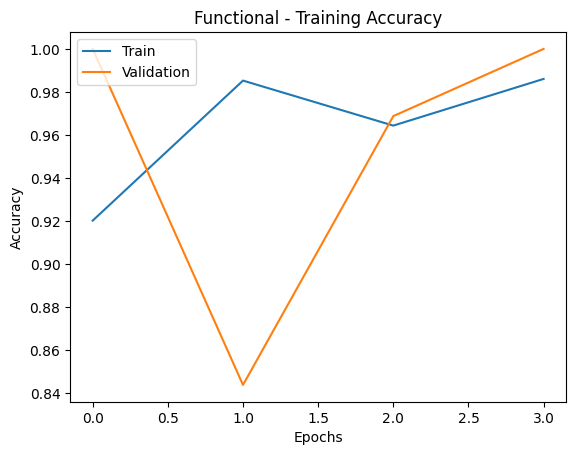

5/5 [==============================] - 120s 27s/step - loss: 2.9918 - accuracy: 0.9067
Test Accuracy: 0.9067
5/5 [==============================] - 43s 7s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.29      0.32      0.30        50
     Powdery       0.37      0.28      0.32        50
        Rust       0.25      0.28      0.26        50

    accuracy                           0.29       150
   macro avg       0.30      0.29      0.29       150
weighted avg       0.30      0.29      0.29       150

Confusion Matrix:
[[16 11 23]
 [16 14 20]
 [23 13 14]]


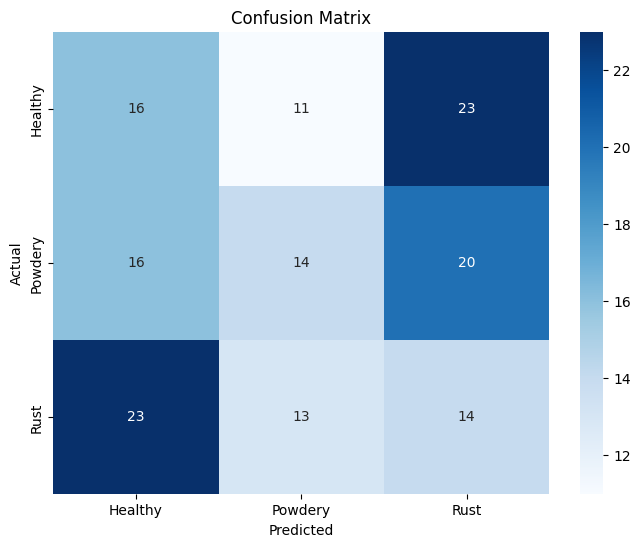

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/datasets/plant_disease/savedmodels/xception.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to your training and test datasets
# Set the paths to your training and test datasets
train_dir = "/content/drive/MyDrive/datasets/plant disease/Train/Train"
test_dir = "/content/drive/MyDrive/datasets/plant disease/Test/Test"
val_dir = "/content/drive/MyDrive/datasets/plant disease/Validation/Validation"
# Set the image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training and test sets with data augmentation

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical",
)

model =    Xception(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))


base_model = model
model_name = base_model.__class__.__name__

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(3, activation="softmax"))

    # Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint to save the best model based on validation loss
model_checkpoint = ModelCheckpoint('best_modelxception.h5', save_best_only=True, monitor='val_loss', mode='min')


model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

# Train the model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

# Generate training accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title(f"{model_name} - Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

#test step
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


# Generate classification report and confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

model_save_path = "/content/drive/MyDrive/datasets/plant_disease/savedmodels/xception.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Epoch 1/20
83/83 [==============================] - 337s 4s/step - loss: 1.0510 - accuracy: 0.4191 - val_loss: 0.8680 - val_accuracy: 0.5000
Epoch 2/20
83/83 [==============================] - 329s 4s/step - loss: 0.8343 - accuracy: 0.5825 - val_loss: 0.7738 - val_accuracy: 0.5333
Epoch 3/20
83/83 [==============================] - 318s 4s/step - loss: 0.8407 - accuracy: 0.5930 - val_loss: 0.7668 - val_accuracy: 0.6000
Epoch 4/20
83/83 [==============================] - 327s 4s/step - loss: 0.7482 - accuracy: 0.6415 - val_loss: 0.7956 - val_accuracy: 0.5333
Epoch 5/20
83/83 [==============================] - 312s 4s/step - loss: 0.7431 - accuracy: 0.6445 - val_loss: 0.6608 - val_accuracy: 0.7167
Epoch 6/20
83/83 [=========================

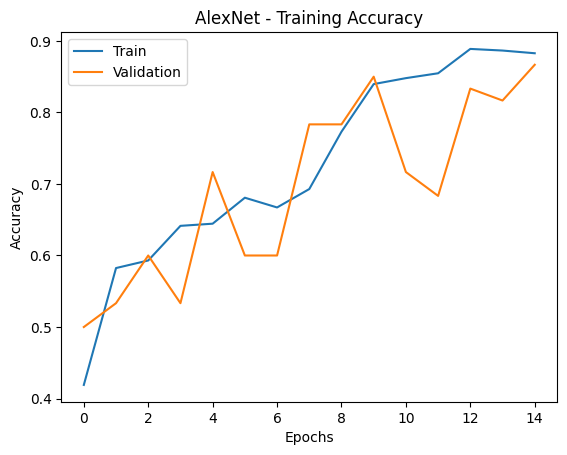

10/10 [==============================] - 15s 1s/step - loss: 0.2774 - accuracy: 0.9133
Test Accuracy: 0.9133
10/10 [==============================] - 14s 1s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.31      0.36      0.33        50
     Powdery       0.39      0.36      0.37        50
        Rust       0.42      0.38      0.40        50

    accuracy                           0.37       150
   macro avg       0.37      0.37      0.37       150
weighted avg       0.37      0.37      0.37       150

Confusion Matrix:
[[18 17 15]
 [21 18 11]
 [20 11 19]]


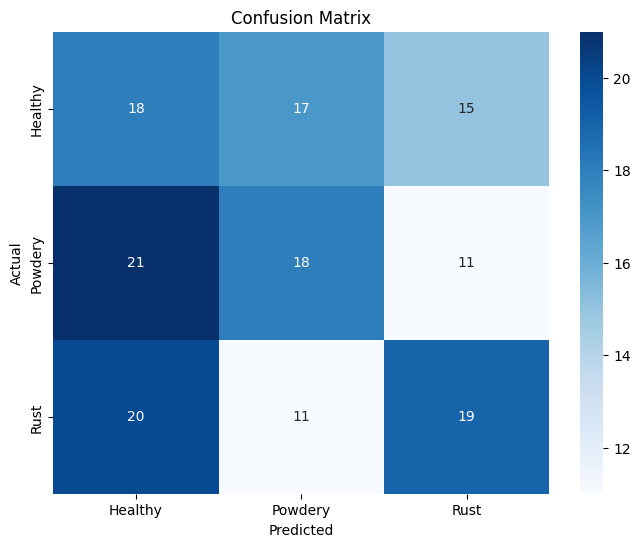

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/datasets/plant_disease/savedmodels/AlexNet.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set the paths to your training and test datasets
train_dir = "/content/drive/MyDrive/datasets/plant disease/Train/Train"
test_dir = "/content/drive/MyDrive/datasets/plant disease/Test/Test"
val_dir = "/content/drive/MyDrive/datasets/plant disease/Validation/Validation"

# Set the image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 16

# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1.2)
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)

# Define the AlexNet model architecture
def create_alexnet_model(input_shape=(224, 224, 3), num_classes=3):
    model = Sequential([
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the model
model = create_alexnet_model()

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)

# Generate training accuracy graph
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("AlexNet - Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate classification report and confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

model_save_path = "/content/drive/MyDrive/datasets/plant_disease/savedmodels/AlexNet.h5"
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Found 150 images belonging to 3 classes.
10/10 [==============================] - 17s 1s/step - loss: 0.1413 - accuracy: 0.9733
Test Accuracy: 0.9733
10/10 [==============================] - 17s 2s/step
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.32      0.34      0.33        50
     Powdery       0.28      0.26      0.27        50
        Rust       0.27      0.28      0.28        50

    accuracy                           0.29       150
   macro avg       0.29      0.29      0.29       150
weighted avg       0.29      0.29      0.29       150

Confusion Matrix:
[[17 16 17]
 [17 13 20]
 [19 17 14]]


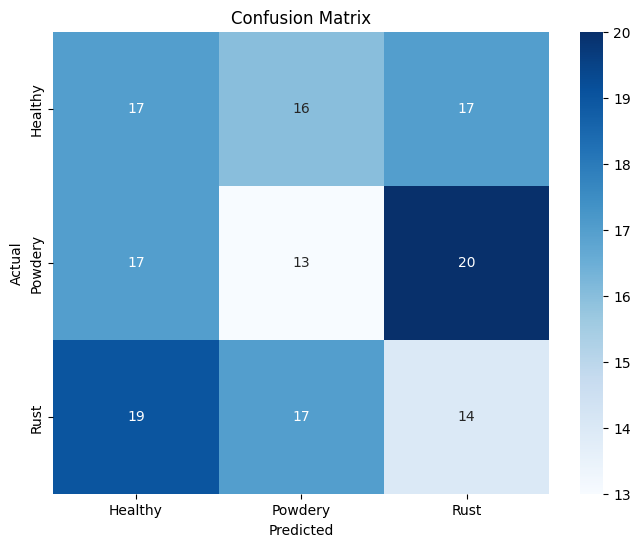

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
img_width, img_height = 224, 224
batch_size = 16
# Load the saved model
model_path = "/content/drive/MyDrive/datasets/plant disease/savedmodels/MobileNetV2.h5"
model = tf.keras.models.load_model(model_path)
test_dir = "/content/drive/MyDrive/datasets/plant disease/Test/Test"

# Data generators for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="categorical"
)
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict classes for the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
